<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo_62/blob/main/Reto1/Reto1_Equipo62.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reto 1 - Limpieza, análisis, visualización y kmeans
## Ciencia y analítica de datos 

## Equipo 62
#### Integrantes:
- Ricardo Morales Bustillos - **A01740032**
- Alejandro Jesús Vázquez Navarro - **A01793146**

#### Profesora: Dra. María de la Paz Rico Fernández

#### 11 de noviembre de 2022


Elige una base de datos, ya sea la de aguas superficiales o la de aguas subterraneas.

1. Limpieza de base de datos.
2. Explorar  cada datos (auxiliate de describe(), mean(), plot, boxplot de pandas):
- a Identificando tendencias centrales promedio, media y mediana de los datos. 
- b Identificar medidas de dispersión, máximo, mínimo .
- c Identificar medidas de posición no centrales , los cuartiles , outliers.   
- d Identificar correlaciones.
- e Preparar los datos 
3. Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.
4. Mostrar resultados de agrupamiento de latitudes y longitudes con K means en el mapa de México.

### En este reto tomaremos la base de datos de aguas superficiales.

In [ ]:
# Carga de librerías necesarias

import pandas as pd
import numpy as np


# Para visualización

%matplotlib inline
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# Para la imputación de datos:
from sklearn.impute import SimpleImputer

# Para escalar los datos:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ParameterGrid

# Para cálculo de intercuartiles
from scipy.stats import iqr

# Para PCA
from sklearn.decomposition import PCA

# Para Kmeans
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Para los pipelines
from sklearn.pipeline import Pipeline

# Para las métricas
from sklearn import metrics 

# Para las gráficas de mapa
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import geoplot.crs as gcrs
import geoplot as gplt
import mapclassify as mc

from shapely.geometry import Point


In [ ]:
# Variables
path = r"C:\Users\aleja\Jupyter Notebooks\maestria\CdD\Retos\Entrega1\Datos_de_calidad_del_agua_2020"
filedb = r"Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv"

filePath = path + "\\" + filedb

DEBUG = False


In [ ]:
# Funciones

def limpieza_caracteres(df, campos):
    
    for i in campos:
        df[i] = df[i].str.replace('<', '')
        
    return df

def correlation_heatmap(dataframe,l,w):
    #correlations = dataframe.corr()
    correlation = dataframe.corr()
    plt.figure(figsize=(l,w))
    sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
    plt.title('Correlation between different fearures')
    plt.show();
    

def KMeans_cluster(data, k):
    my_kmeans = KMeans(n_clusters= k)
    my_kmeans.fit(data) 
    clusters = my_kmeans.predict(data) 
    centroids = my_kmeans.cluster_centers_
    return clusters,  pd.DataFrame(centroids)
    


In [ ]:
# BORRAR
#https://medium.com/predict/dimensionality-reduction-using-python-principal-component-analysis-fb365f39ae5c
    

In [ ]:
# Adquisición de datos

dfMain = pd.read_csv(filePath)
dfMain.head()


y = dfMain["SEMAFORO"]
lat = dfMain["LATITUD"]
long = dfMain["LONGITUD"]

coordenadas = dfMain[["LATITUD", "LONGITUD"]]


# 1. Limpieza de datos:

In [ ]:
# Para tener una visión amplia de las cosas

dfMain.shape


(3493, 55)

### Insights:
- Podemos observar que tenemos una base de datos con 3493 observaciones y 55 columnas

### Contar NaN's

In [ ]:
dfMain.isnull().sum()

CLAVE                        0
SITIO                        0
ORGANISMO_DE_CUENCA          0
ESTADO                       0
MUNICIPIO                    0
CUENCA                       1
CUERPO DE AGUA              14
TIPO                         0
SUBTIPO                     14
LONGITUD                     0
LATITUD                      0
PERIODO                      0
DBO_mg/L                   912
CALIDAD_DBO                912
DQO_mg/L                   912
CALIDAD_DQO                912
SST_mg/L                     4
CALIDAD_SST                  4
COLI_FEC_NMP_100mL         911
CALIDAD_COLI_FEC           911
E_COLI_NMP_100mL           911
CALIDAD_E_COLI             911
ENTEROC_NMP_100mL         2589
CALIDAD_ENTEROC           2589
OD_PORC                   1696
CALIDAD_OD_PORC           1696
OD_PORC_SUP               1874
CALIDAD_OD_PORC_SUP       1874
OD_PORC_MED               3006
CALIDAD_OD_PORC_MED       3006
OD_PORC_FON               2547
CALIDAD_OD_PORC_FON       2547
TOX_D_48

### Insights:
Las columnas con datos completos son:
- CLAVE                        
- SITIO                        
- ORGANISMO_DE_CUENCA          
- ESTADO                       
- MUNICIPIO                    
- TIPO
- LONGITUD                     
- LATITUD                      
- PERIODO  
- SEMAFORO
- CUMPLE_CON_DBO               
- CUMPLE_CON_DQO               
- CUMPLE_CON_SST               
- CUMPLE_CON_CF                
- CUMPLE_CON_E_COLI            
- CUMPLE_CON_ENTEROC           
- CUMPLE_CON_OD                
- CUMPLE_CON_TOX               
- GRUPO      

A todas luces tendremos que realizar imputación de datos. Para este sentido, primero tenemos que conocer la calidad de todos los datos y determinar si tenemos que hacer transformaciones, limpieza, eliminación o sustitución de datos.

En una observación ocular muy simple pudimos encontrar que las columnas: 
- DBO_mg/L
- DQO_mg/L
- SST_mg/L
- COLI_FEC_NMP_100mL
- E_COLI_NMP_100mL
- ENTEROC_NMP_100mL
- OD_PORC
- OD_PORC_SUP
- OD_PORC_MED
- OD_PORC_FON
- TOX_D_48_UT
- TOX_V_15_UT
- TOX_D_48_SUP_UT
- TOX_FIS_SUP_15_UT

contienen datos mezclados, es decir, tienen datos de tipo cadena "<" y enteros o flotantes.



In [ ]:
# Podemos remover el caracter "<" en todo el dataframe así:

dfMain = dfMain.replace('<', '', regex=True)

# Debido a que las variables TOX_D_48_FON_UT, CALIDAD_TOX_D_48_FON, TOX_FIS_FON_15_UT, CALIDAD_TOX_FIS_FON_15 
# no tienen datos, las eliminaremos
# También eliminaré PERIODO pues todo es del 2020

colsEliminiar = ["PERIODO","TOX_D_48_FON_UT","CALIDAD_TOX_D_48_FON", "TOX_FIS_FON_15_UT", "CALIDAD_TOX_FIS_FON_15"]
dfMain.drop(columns = colsEliminiar, inplace=True)

In [ ]:
dfMain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3493 entries, 0 to 3492
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  DBO_mg/L                2581 non-null   object 
 12  CALIDAD_DBO             2581 non-null   object 
 13  DQO_mg/L                2581 non-null   object 
 14  CALIDAD_DQO             2581 non-null   

### Primera tarea de transformación de datos:
#### 01 - Limpieza 

In [ ]:
# Solo para entender la distribución de algunas variables que tenían el caracter ">", realizamos
# este análisis de histograma

camposLimpiarCaracter = ["DBO_mg/L", "DQO_mg/L", "SST_mg/L", "COLI_FEC_NMP_100mL", "E_COLI_NMP_100mL",
                         "ENTEROC_NMP_100mL", "OD_PORC", "OD_PORC_SUP", "OD_PORC_MED", "OD_PORC_FON", 
                         "TOX_D_48_UT", "TOX_V_15_UT", "TOX_D_48_SUP_UT", "TOX_FIS_SUP_15_UT"]


if DEBUG==True:

    # Gráfica de estas variables para entender si usaremos mediana o media en la técnica de imputación
    sns.set(rc={'figure.figsize':(17,16)})
    fig, axes = plt.subplots(4, 4)    
    dfHist = dfMain[camposLimpiarCaracter]

    for i in range(0, 14):

        plt.subplot(4,4,i+1) 

        Transf0 = dfHist[camposLimpiarCaracter[i]]         
        sns.histplot(data=Transf0, bins=20)                

        plt.xlabel(camposLimpiarCaracter[i])
        if i==0:
              plt.ylabel('Valor')

    


### Insights:

Una revisión ocular nos permite identificar outliers y distribuciones asimétricas; con esto es suficiente para poder elegir la mediana como método de imputación en nuestros valores **NaN**.


In [ ]:
# Realizamos una copia del dfMain
dfLimpieza01 = dfMain.copy()

# Almacenamos los campos en una variable X
X = dfLimpieza01[camposLimpiarCaracter] 

imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=1)

# Rellenamos los NaN con mediana
transformed_values = imputer.fit_transform(X)

column = X.columns

dfLimpiezaA = pd.DataFrame(transformed_values, columns = column )

# Verificamos si existen NaN
dfLimpiezaA.isnull().sum()

# Ya no existen NaN




DBO_mg/L              0
DQO_mg/L              0
SST_mg/L              0
COLI_FEC_NMP_100mL    0
E_COLI_NMP_100mL      0
ENTEROC_NMP_100mL     0
OD_PORC               0
OD_PORC_SUP           0
OD_PORC_MED           0
OD_PORC_FON           0
TOX_D_48_UT           0
TOX_V_15_UT           0
TOX_D_48_SUP_UT       0
TOX_FIS_SUP_15_UT     0
dtype: int64

In [ ]:
# Por las magnitudes de las variables es necesario escalaras:

# Realizamos una copia del dfMain
dfLimpieza02 = dfLimpiezaA.copy()

# Almacenamos los campos en una variable X
X = dfLimpieza02[camposLimpiarCaracter] 

scaler = MinMaxScaler()

# Escalamos
scaled = scaler.fit_transform(X)

column = X.columns

dfLimpiezaB = pd.DataFrame(scaled, columns = column )

# Verificamos si existen NaN
dfLimpiezaB.isnull().sum()

# Ya no existen NaN




DBO_mg/L              0
DQO_mg/L              0
SST_mg/L              0
COLI_FEC_NMP_100mL    0
E_COLI_NMP_100mL      0
ENTEROC_NMP_100mL     0
OD_PORC               0
OD_PORC_SUP           0
OD_PORC_MED           0
OD_PORC_FON           0
TOX_D_48_UT           0
TOX_V_15_UT           0
TOX_D_48_SUP_UT       0
TOX_FIS_SUP_15_UT     0
dtype: int64

In [ ]:
# Veamos si describe nos devuelve métricas numéricas
dfLimpiezaB.describe().T

,count,mean,std,min,25%,50%,75%,max
DBO_mg/L,3493.0,0.007453,0.037611,0.0,0.000000,0.000421,0.003178,1.0
DQO_mg/L,3493.0,0.015583,0.045373,0.0,0.002356,0.005945,0.011401,1.0
SST_mg/L,3493.0,0.009773,0.046881,0.0,0.000000,0.001518,0.004989,1.0
COLI_FEC_NMP_100mL,3493.0,0.002949,0.041567,0.0,0.000035,0.000099,0.000454,1.0
E_COLI_NMP_100mL,3493.0,0.002428,0.037383,0.0,0.000004,0.000017,0.000099,1.0
ENTEROC_NMP_100mL,3493.0,0.011593,0.092610,0.0,0.000000,0.000000,0.000000,1.0
OD_PORC,3493.0,0.266307,0.104317,0.0,0.265618,0.269783,0.274873,1.0
OD_PORC_SUP,3493.0,0.261206,0.069845,0.0,0.265591,0.265591,0.265591,1.0
OD_PORC_MED,3493.0,0.506400,0.080014,0.0,0.507317,0.507317,0.507317,1.0
OD_PORC_FON,3493.0,0.421538,0.107876,0.0,0.422794,0.422794,0.422794,1.0


### Insights:

Confirmado, ya no tenemos datos NaN sin embargo ahora tenemos que concatenar estos campos transformados al dataset original



In [ ]:
dfMain = dfMain.drop(columns=camposLimpiarCaracter)

dfLimpiezaC = pd.concat([dfMain, dfLimpiezaB], axis=1)

#Verificamos la forma, debe ser de (3493, 51)
dfLimpiezaC.shape

(3493, 50)

### Insights:

Excelente, tenemos la misma forma original; ahora correremos nuevamente nuestra verificación de datos nulos


In [ ]:
dfMain2 = dfLimpiezaC.copy()
camposNulos = dfMain2.isnull().sum()

print(f"Campos aún nulos: ")
print(camposNulos[camposNulos > 0])



categoricas = ["CUENCA", "CUERPO DE AGUA", "SUBTIPO", "CALIDAD_DBO", "CALIDAD_DQO", "CALIDAD_SST",
              "CALIDAD_COLI_FEC", "CALIDAD_E_COLI", "CALIDAD_ENTEROC", "CALIDAD_OD_PORC",  "CALIDAD_OD_PORC_SUP",
               "CALIDAD_OD_PORC_MED", "CALIDAD_OD_PORC_FON", "CALIDAD_TOX_D_48", "CALIDAD_TOX_V_15", 
               "CALIDAD TOX_D_48_SUP", "CALIDAD_TOX_FIS_SUP_15", "CONTAMINANTES"]
                              
               
dfMain2[categoricas].info()

Campos aún nulos: 
CUENCA                       1
CUERPO DE AGUA              14
SUBTIPO                     14
CALIDAD_DBO                912
CALIDAD_DQO                912
CALIDAD_SST                  4
CALIDAD_COLI_FEC           911
CALIDAD_E_COLI             911
CALIDAD_ENTEROC           2589
CALIDAD_OD_PORC           1696
CALIDAD_OD_PORC_SUP       1874
CALIDAD_OD_PORC_MED       3006
CALIDAD_OD_PORC_FON       2547
CALIDAD_TOX_D_48          1677
CALIDAD_TOX_V_15          1674
CALIDAD TOX_D_48_SUP      2731
CALIDAD_TOX_FIS_SUP_15    1819
CONTAMINANTES             1267
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3493 entries, 0 to 3492
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CUENCA                  3492 non-null   object
 1   CUERPO DE AGUA          3479 non-null   object
 2   SUBTIPO                 3479 non-null   object
 3   CALIDAD_DBO             2581 non-null 

### Insights:
Corramos ahora nuestro trabajo de imputación en estas variables categóricas. Esto pudo realizarse en un solo paso pero para fines demostrativos se realizó en 2 pasos.

Primer la limpíeza de variables numéricas y después la limpieza de variables categóricas


In [ ]:
X = dfMain2[categoricas] 

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
transformed_values = imputer.fit_transform(X)

column = X.columns
print(column)

dfLimpiezaD = pd.DataFrame(transformed_values, columns = column )

# Verificamos si existen NaN

dfLimpiezaD.isnull().sum()

Index(['CUENCA', 'CUERPO DE AGUA', 'SUBTIPO', 'CALIDAD_DBO', 'CALIDAD_DQO',
       'CALIDAD_SST', 'CALIDAD_COLI_FEC', 'CALIDAD_E_COLI', 'CALIDAD_ENTEROC',
       'CALIDAD_OD_PORC', 'CALIDAD_OD_PORC_SUP', 'CALIDAD_OD_PORC_MED',
       'CALIDAD_OD_PORC_FON', 'CALIDAD_TOX_D_48', 'CALIDAD_TOX_V_15',
       'CALIDAD TOX_D_48_SUP', 'CALIDAD_TOX_FIS_SUP_15', 'CONTAMINANTES'],
      dtype='object')


CUENCA                    0
CUERPO DE AGUA            0
SUBTIPO                   0
CALIDAD_DBO               0
CALIDAD_DQO               0
CALIDAD_SST               0
CALIDAD_COLI_FEC          0
CALIDAD_E_COLI            0
CALIDAD_ENTEROC           0
CALIDAD_OD_PORC           0
CALIDAD_OD_PORC_SUP       0
CALIDAD_OD_PORC_MED       0
CALIDAD_OD_PORC_FON       0
CALIDAD_TOX_D_48          0
CALIDAD_TOX_V_15          0
CALIDAD TOX_D_48_SUP      0
CALIDAD_TOX_FIS_SUP_15    0
CONTAMINANTES             0
dtype: int64

# Insights:

Ya no tenemos nulos, ahora hay que agregar al dataframe principal



In [ ]:
dfMain3 = dfMain2.drop(columns=categoricas)

dfLimpiezaE= pd.concat([dfMain3,dfLimpiezaD], axis=1)

#Verificamos la forma, debe ser de (3493, 50)
dfLimpiezaE.shape

(3493, 50)

#### La forma de la matriz es correcta, podemos continuar (3493, 50)


## Verificamos la calidad de los datos

In [ ]:
dfMain4 =  dfLimpiezaE.copy()

dfMain4.isnull().sum()


CLAVE                     0
SITIO                     0
ORGANISMO_DE_CUENCA       0
ESTADO                    0
MUNICIPIO                 0
TIPO                      0
LONGITUD                  0
LATITUD                   0
SEMAFORO                  0
CUMPLE_CON_DBO            0
CUMPLE_CON_DQO            0
CUMPLE_CON_SST            0
CUMPLE_CON_CF             0
CUMPLE_CON_E_COLI         0
CUMPLE_CON_ENTEROC        0
CUMPLE_CON_OD             0
CUMPLE_CON_TOX            0
GRUPO                     0
DBO_mg/L                  0
DQO_mg/L                  0
SST_mg/L                  0
COLI_FEC_NMP_100mL        0
E_COLI_NMP_100mL          0
ENTEROC_NMP_100mL         0
OD_PORC                   0
OD_PORC_SUP               0
OD_PORC_MED               0
OD_PORC_FON               0
TOX_D_48_UT               0
TOX_V_15_UT               0
TOX_D_48_SUP_UT           0
TOX_FIS_SUP_15_UT         0
CUENCA                    0
CUERPO DE AGUA            0
SUBTIPO                   0
CALIDAD_DBO         

### Insights
No tenemos nulos, hemos terminado las tareas de limpieza


# 2. Explorar cada datos (auxiliate de describe(), mean(), plot, boxplot de pandas):


In [ ]:
# De esta manera podemos revisar medidas de centralidad, cantidad de observaciones por variable numérica
# valor mínimo, cuartiles, valor máximo y desviación estándar

dfMain4.describe().T


,count,mean,std,min,25%,50%,75%,max
LONGITUD,3493.0,-100.359969,6.122773,-117.12403,-103.882310,-99.795530,-96.860230,-86.73215
LATITUD,3493.0,21.046992,3.893696,14.53491,18.396070,20.148980,22.828930,32.70650
DBO_mg/L,3493.0,0.007453,0.037611,0.00000,0.000000,0.000421,0.003178,1.00000
DQO_mg/L,3493.0,0.015583,0.045373,0.00000,0.002356,0.005945,0.011401,1.00000
SST_mg/L,3493.0,0.009773,0.046881,0.00000,0.000000,0.001518,0.004989,1.00000
COLI_FEC_NMP_100mL,3493.0,0.002949,0.041567,0.00000,0.000035,0.000099,0.000454,1.00000
E_COLI_NMP_100mL,3493.0,0.002428,0.037383,0.00000,0.000004,0.000017,0.000099,1.00000
ENTEROC_NMP_100mL,3493.0,0.011593,0.092610,0.00000,0.000000,0.000000,0.000000,1.00000
OD_PORC,3493.0,0.266307,0.104317,0.00000,0.265618,0.269783,0.274873,1.00000
OD_PORC_SUP,3493.0,0.261206,0.069845,0.00000,0.265591,0.265591,0.265591,1.00000


### Creación de gráfica boxplot para las variables numéricas listadas arriba


In [ ]:
# Eliminaré LONGITUD, LATITUD, PERIODO pues no tiene sentido analizarlas en esta gráfica

colsNumericas = ["DBO_mg/L", "DQO_mg/L", "SST_mg/L", "COLI_FEC_NMP_100mL",
                 "E_COLI_NMP_100mL", "ENTEROC_NMP_100mL", "OD_PORC", "OD_PORC_SUP", "OD_PORC_MED", "OD_PORC_FON",
                 "TOX_D_48_UT", "TOX_V_15_UT", "TOX_D_48_SUP_UT", "TOX_FIS_SUP_15_UT"]

dfBoxPlot = dfMain4[colsNumericas]

dfBoxPlot.head()



,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
0,0.002670,0.015406,0.000398,0.000048,0.000004,0.000000,0.269783,0.131900,0.507317,0.422794,0.0,0.0,0.0,0.0
1,0.000421,0.005945,0.000000,0.000099,0.000017,0.000703,0.269783,0.293907,0.694309,0.604412,0.0,0.0,0.0,0.0
2,0.000421,0.005945,0.000000,0.000099,0.000017,0.000000,0.269783,0.293907,0.694309,0.604412,0.0,0.0,0.0,0.0
3,0.000421,0.005945,0.000421,0.000099,0.000017,0.000000,0.269783,0.265591,0.507317,0.563971,0.0,0.0,0.0,0.0
4,0.000421,0.005945,0.000000,0.000099,0.000017,0.001116,0.269783,0.308961,0.698374,0.628676,0.0,0.0,0.0,0.0


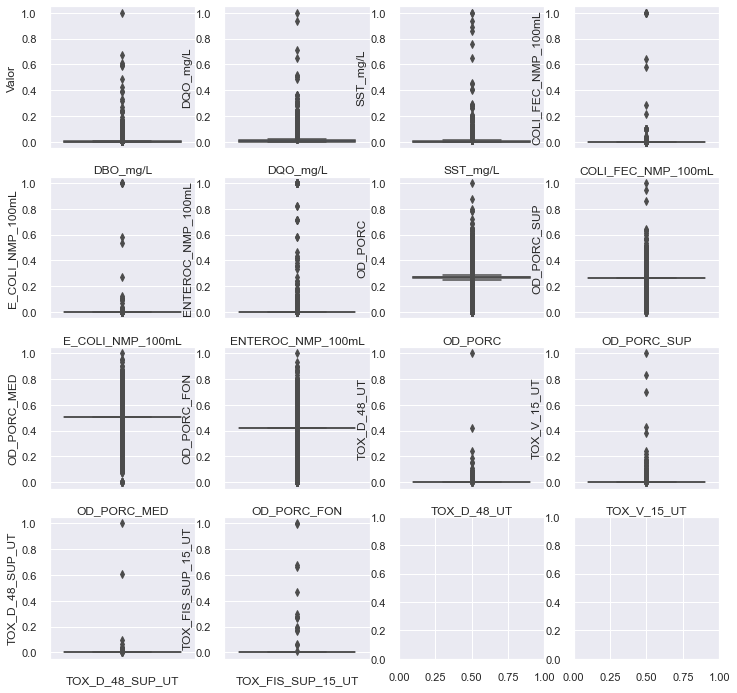

In [ ]:
DEBUG = True

if DEBUG==True:

   # Gráfica de estas variables para entender si usaremos mediana o media en la técnica de imputación
    sns.set(rc={'figure.figsize':(12,12)})
    fig, axes = plt.subplots(4, 4)    
    dfHist = dfBoxPlot

    for i in range(0, 14):

        plt.subplot(4,4,i+1) 

        Transf0 = dfHist[colsNumericas[i]]         
        sns.boxplot(y =Transf0 )                

        plt.xlabel(colsNumericas[i])
        if i==0:
              plt.ylabel('Valor')


### a. Identificando tendencias centrales promedio, media y mediana de los datos

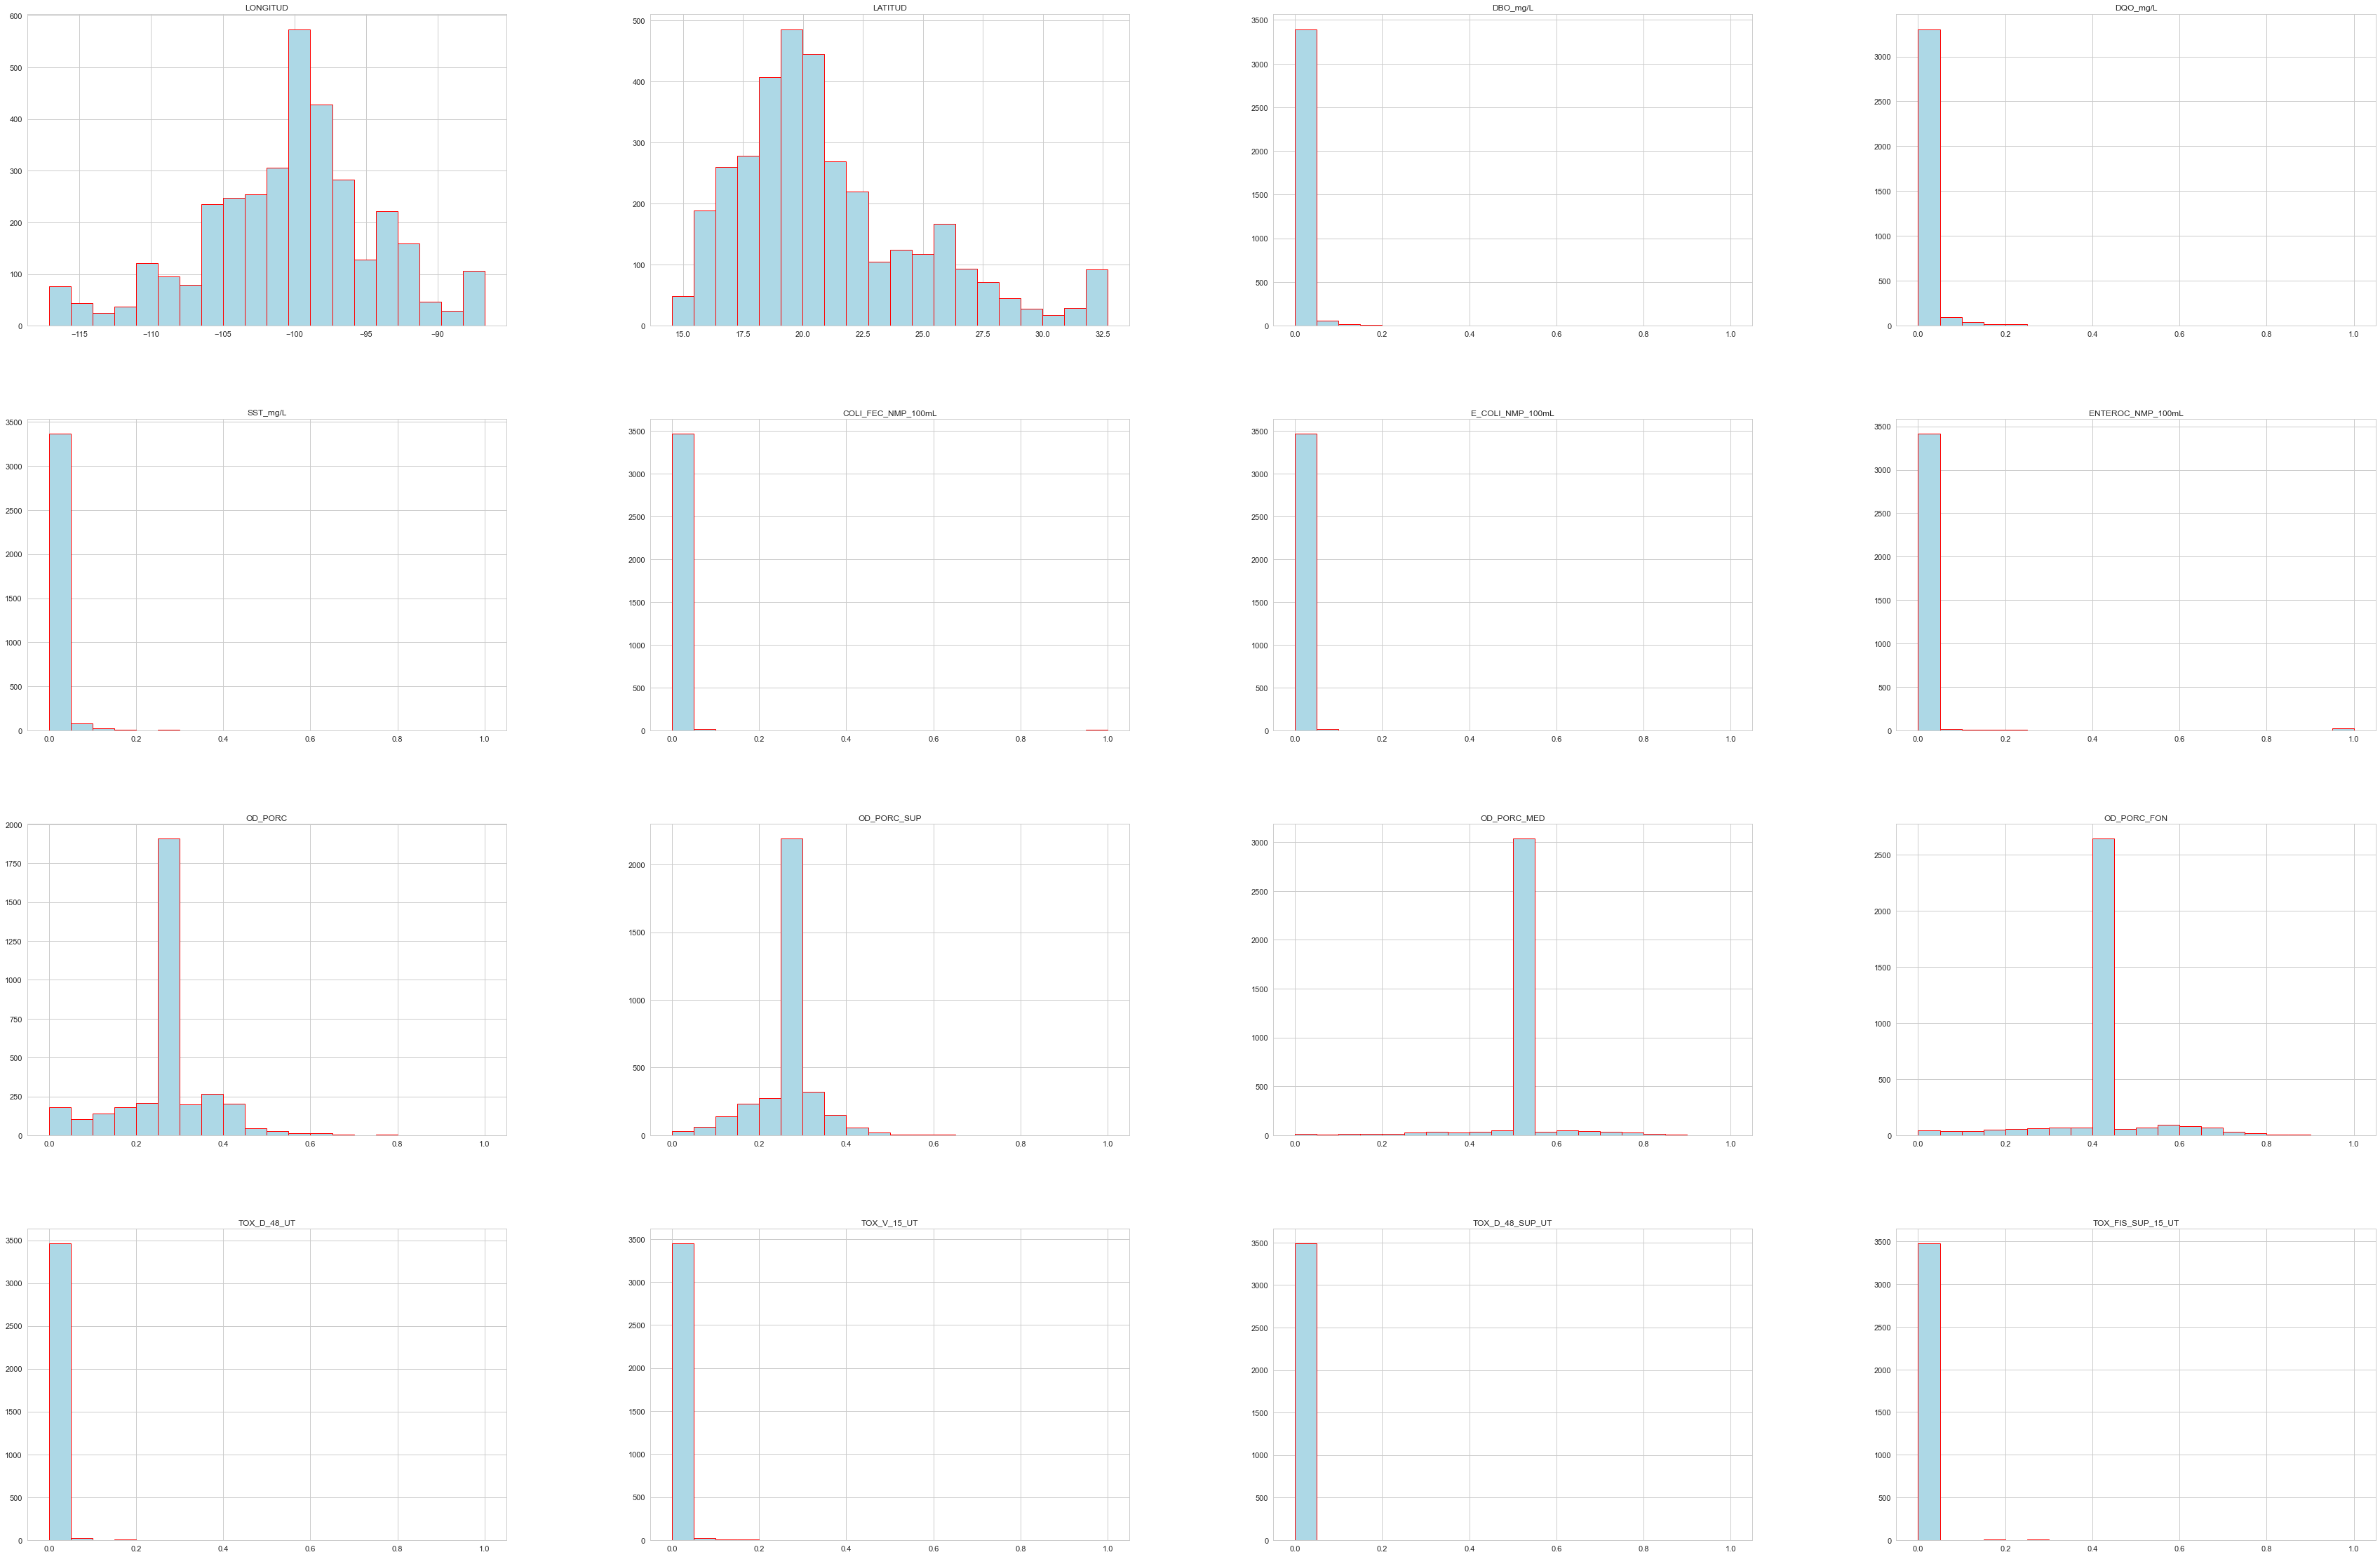

In [ ]:

plt.style.use('seaborn-whitegrid')
dfMain4.hist(bins=20, figsize=(60,40), color='lightblue', edgecolor = 'red')
plt.show()

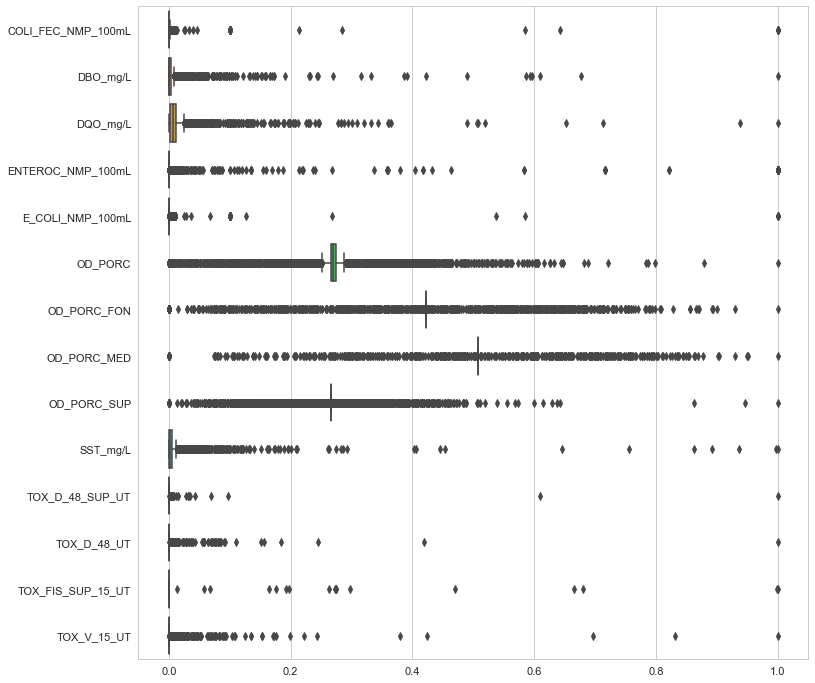

In [ ]:
ax = sns.boxplot(data=dfMain4[dfMain4.columns.difference(["LONGITUD", "LATITUD"])], orient="h")


Con esta gráfica general, nos podemos dar cuenta de las variables que guardan algún tipo de correlación.
Por ejemplo, `DQO_mg/l` guarda una correlación fuerte con `DBO_mgl`, mismo caso con `COLI_FEC_NMP_100mL` y `ECOLI_NPM_100mL`.

También puede observarse una correlación fuerte positiva con la variable `OD_PORC_FON` y `OD_PORC_MERC` y `OD_PORC_SUP` respectivamente.

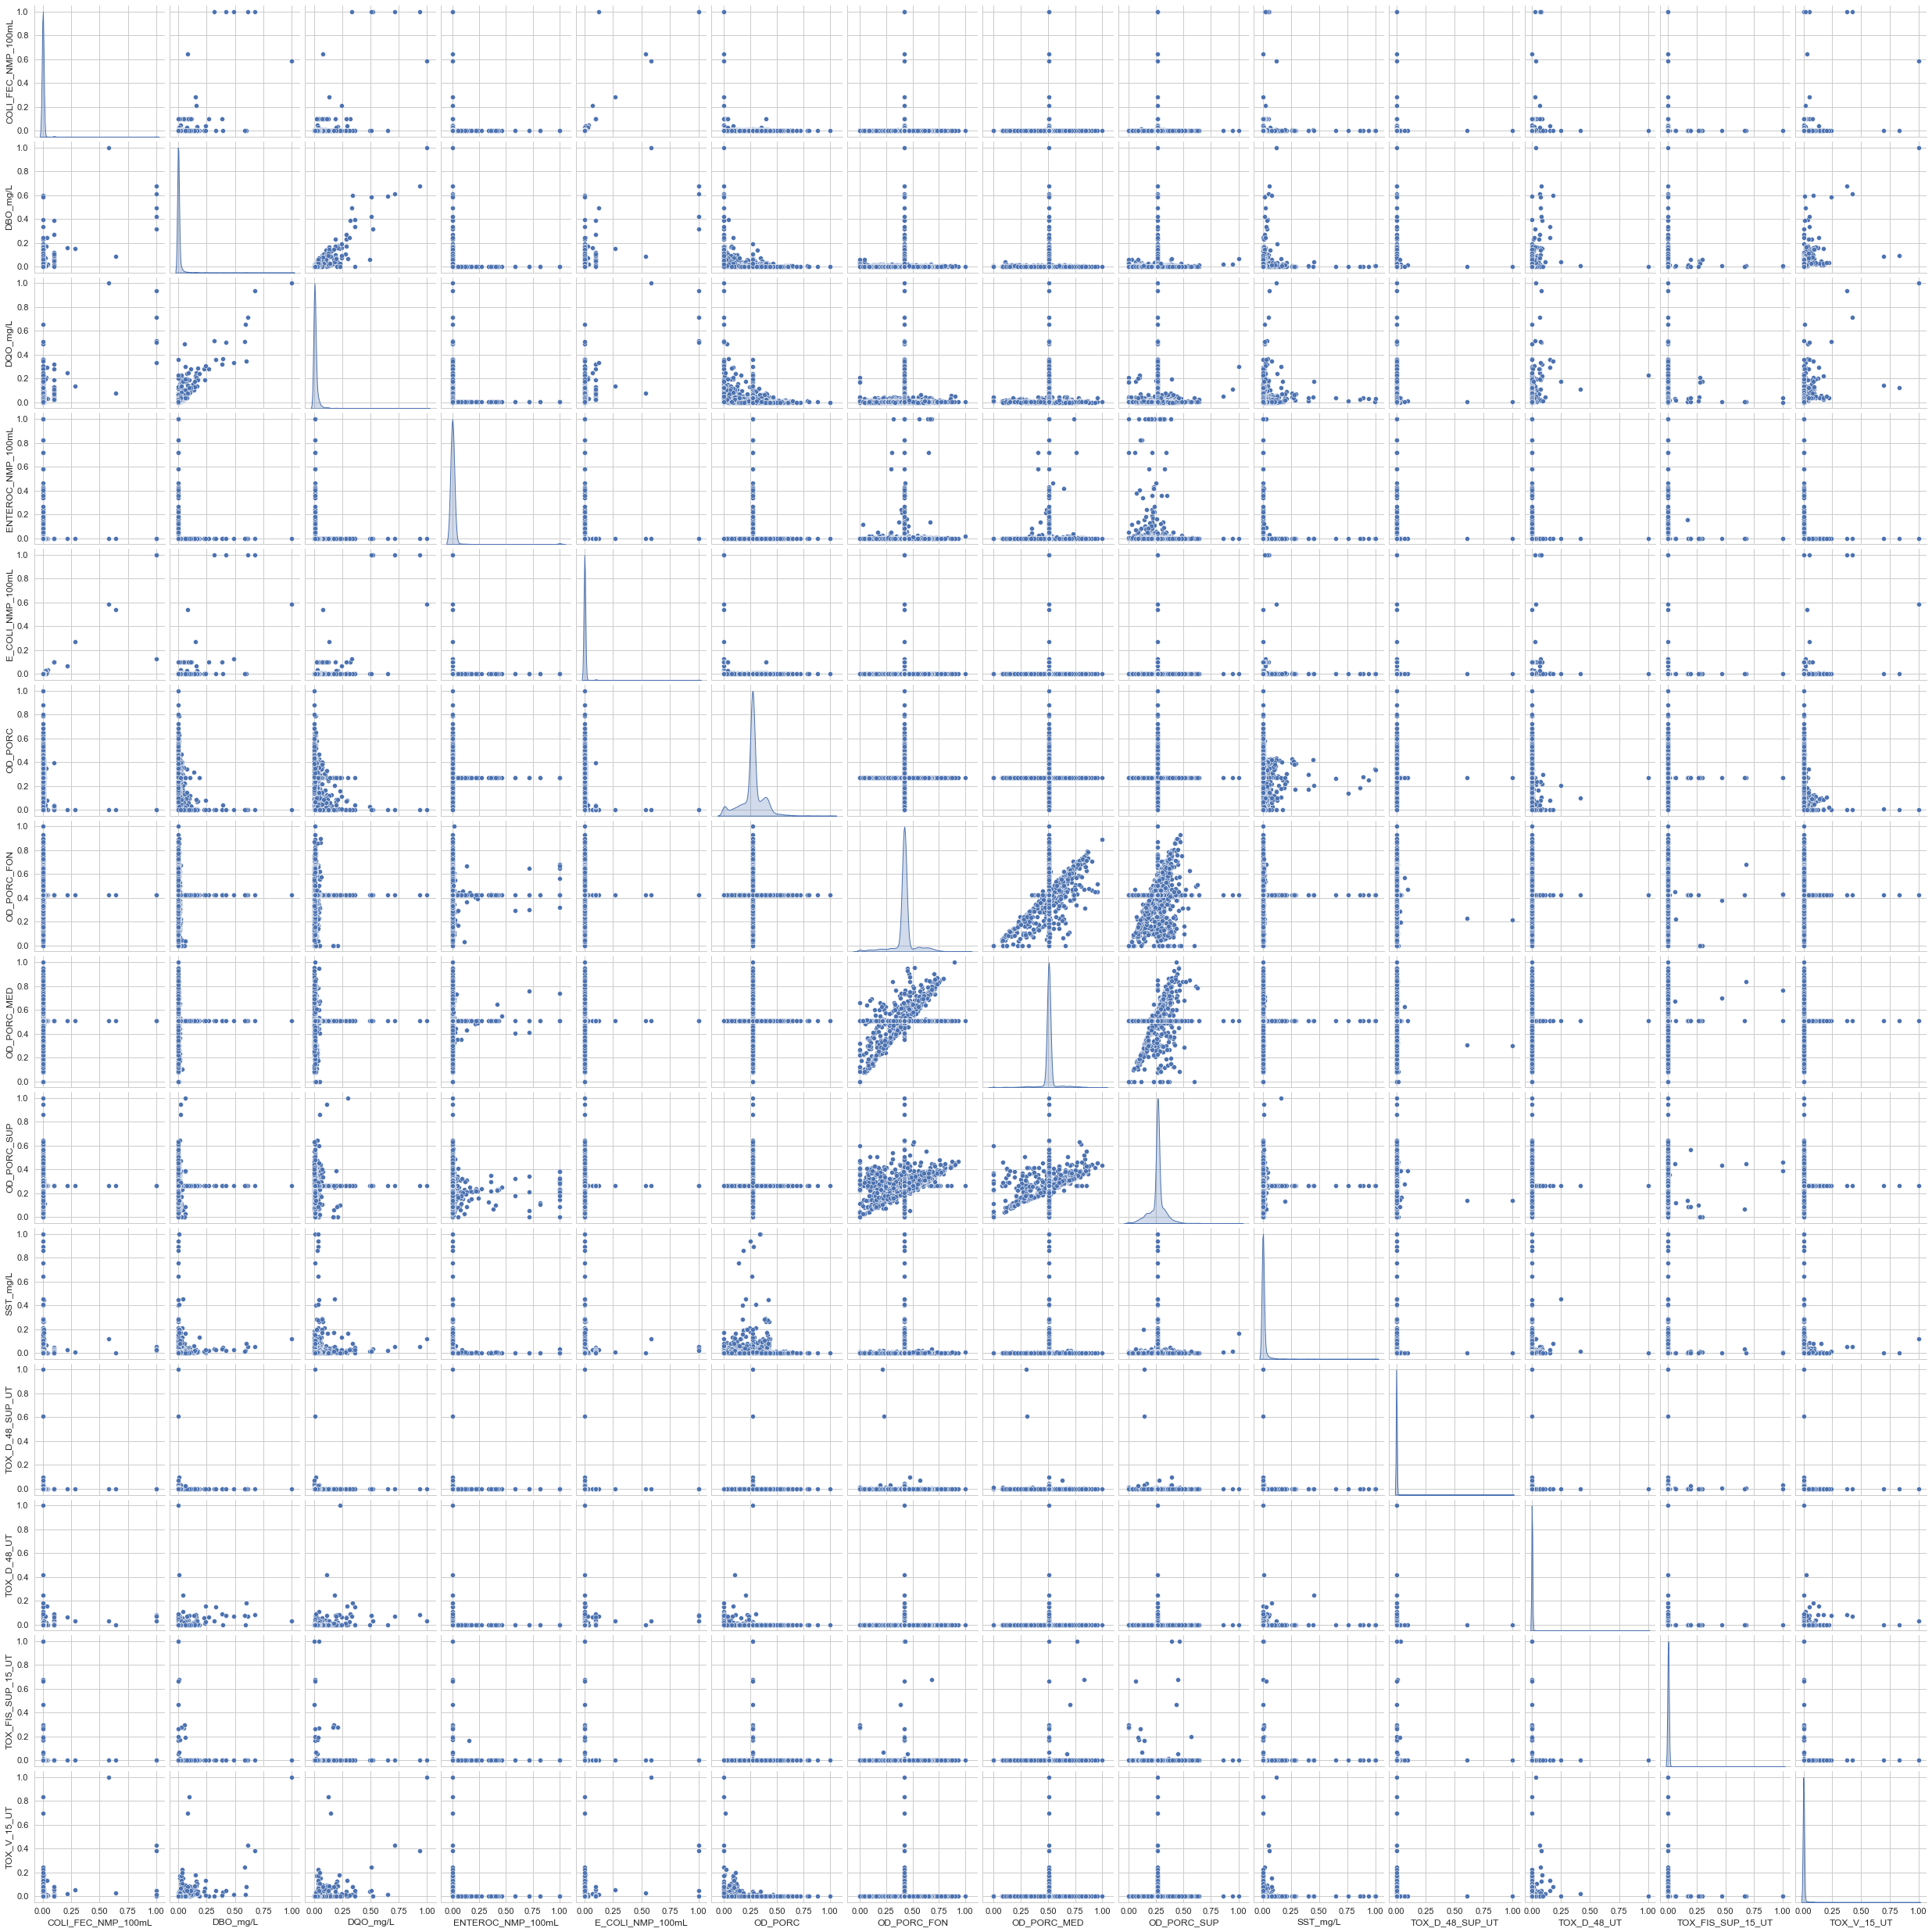

In [ ]:
sns.pairplot(dfMain4[dfMain4.columns.difference(["LONGITUD", "LATITUD"])], diag_kind="kde")


 ### b Identificar medidas de dispersión, máximo, mínimo .

In [ ]:
dfMain4[dfMain4.columns.difference(["LONGITUD", "LATITUD"])].describe().loc[['max', 'min', 'std']].T

,max,min,std
COLI_FEC_NMP_100mL,1.0,0.0,0.041567
DBO_mg/L,1.0,0.0,0.037611
DQO_mg/L,1.0,0.0,0.045373
ENTEROC_NMP_100mL,1.0,0.0,0.092610
E_COLI_NMP_100mL,1.0,0.0,0.037383
OD_PORC,1.0,0.0,0.104317
OD_PORC_FON,1.0,0.0,0.107876
OD_PORC_MED,1.0,0.0,0.080014
OD_PORC_SUP,1.0,0.0,0.069845
SST_mg/L,1.0,0.0,0.046881


### c Identificar medidas de posición no centrales , los cuartiles , outliers.   


In [ ]:

dfMainIQR = dfMain4[dfMain4.columns.difference(["LONGITUD", "LATITUD"])]

Q1 = dfMainIQR.quantile(0.25)
Q3 = dfMainIQR.quantile(0.75)
IQR = Q3 - Q1
print(f"Distancia Intercuartil:")
      
print(IQR)

cleandf = dfMainIQR[~((dfMainIQR < (Q1 - 1.5 * IQR)) |(dfMainIQR > (Q3 + 1.5 * IQR))).any(axis=1)]
cleandf.shape


Distancia Intercuartil:
COLI_FEC_NMP_100mL    0.000419
DBO_mg/L              0.003178
DQO_mg/L              0.009045
ENTEROC_NMP_100mL     0.000000
E_COLI_NMP_100mL      0.000095
OD_PORC               0.009255
OD_PORC_FON           0.000000
OD_PORC_MED           0.000000
OD_PORC_SUP           0.000000
SST_mg/L              0.004989
TOX_D_48_SUP_UT       0.000000
TOX_D_48_UT           0.000000
TOX_FIS_SUP_15_UT     0.000000
TOX_V_15_UT           0.000000
dtype: float64


(110, 48)

### d. Identificar correlaciones



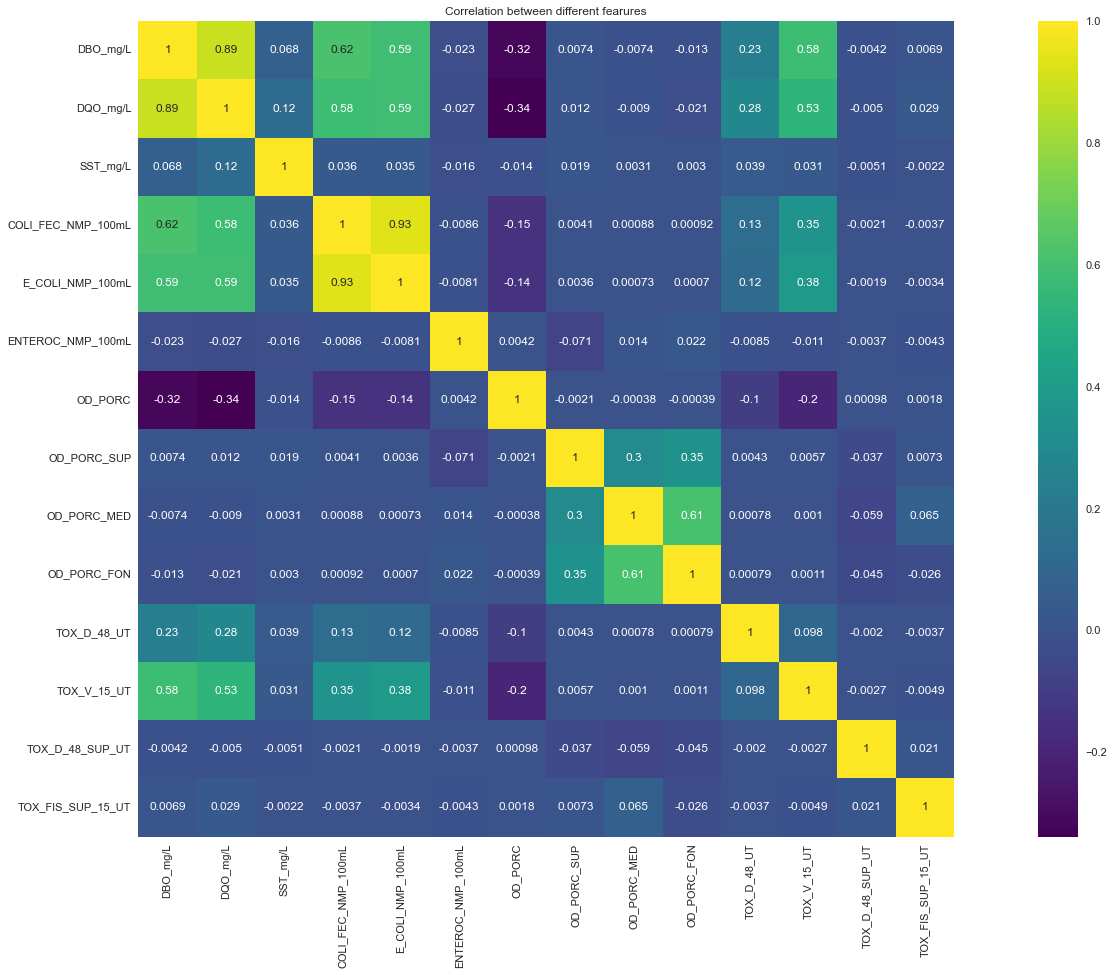

In [ ]:

# Let's Drop Class column and see the correlation Matrix & Pairplot Before using this dataframe for PCA as PCA should only be perfromed on independent attribute
cleandf= dfBoxPlot
#print("After Dropping: ", cleandf)
correlation_heatmap(cleandf, 30,15)

### Insights:

Podemos identificar algunas correlaciones pero todas son débiles. Los datos no guardan relaciones lineales. La correlación más importante es `DQO_mgL y DBO_mgl`, `COLI_FEC_NMP_100ml y E_COLI_NMP`, `OD_PORC_MED y OD_PORC_FON`.

La cantidad de variables exige una reducción dimensionalidad, si bien el reto no lo exige, procederemos a realizar la reducción usando la técnica PCA.

# PCA

In [ ]:
#Elegir con cuáles columnas nos quedaremos y qué tratamiento le daremos

colCategoricas = ["TIPO", "SUBTIPO", "CALIDAD_DBO", "CALIDAD_DQO", "CALIDAD_SST", "CALIDAD_COLI_FEC", "CALIDAD_E_COLI",
                 "CALIDAD_ENTEROC", "CALIDAD_OD_PORC", "CALIDAD_OD_PORC_SUP", "CALIDAD_OD_PORC_MED", "CALIDAD_OD_PORC_FON",
                 "CALIDAD_TOX_D_48", "CALIDAD_TOX_V_15", "CALIDAD TOX_D_48_SUP", "CALIDAD_TOX_FIS_SUP_15",
                  "CONTAMINANTES", ""
                 "CUMPLE_CON_DBO","CUMPLE_CON_DQO","CUMPLE_CON_SST","CUMPLE_CON_CF",
                  "CUMPLE_CON_E_COLI","CUMPLE_CON_ENTEROC","CUMPLE_CON_OD","CUMPLE_CON_TOX","GRUPO"
                 ]

colNumericas = ["COLI_FEC_NMP_100mL","DBO_mg/L","DQO_mg/L","ENTEROC_NMP_100mL","E_COLI_NMP_100mL",
                "OD_PORC","OD_PORC_FON","OD_PORC_MED","OD_PORC_SUP","SST_mg/L",
                "TOX_D_48_SUP_UT",
                "TOX_D_48_UT","TOX_FIS_SUP_15_UT","TOX_V_15_UT"]

colLatitudLongitud= ["LONGITUD", "LATITUD"]



#### Transformación de los datos para PCA


In [ ]:
# OneHotEncoded

dfMain4["Coordenadas"] = dfMain4["LATITUD"].astype(str) + "," + dfMain4["LONGITUD"].astype(str)

dfTrabajo = dfMain4
dfTrabajo = dfTrabajo.set_index("Coordenadas")

X = pd.DataFrame(dfMain4, columns = colCategoricas)
print(X.columns)

imputer = OneHotEncoder(categories='auto')
transformed_values = imputer.fit_transform(X).toarray()

column = imputer.get_feature_names(colCategoricas)

dfOneHotEncoded = pd.DataFrame(transformed_values, columns = column )
dfOneHotEncoded


Index(['TIPO', 'SUBTIPO', 'CALIDAD_DBO', 'CALIDAD_DQO', 'CALIDAD_SST',
       'CALIDAD_COLI_FEC', 'CALIDAD_E_COLI', 'CALIDAD_ENTEROC',
       'CALIDAD_OD_PORC', 'CALIDAD_OD_PORC_SUP', 'CALIDAD_OD_PORC_MED',
       'CALIDAD_OD_PORC_FON', 'CALIDAD_TOX_D_48', 'CALIDAD_TOX_V_15',
       'CALIDAD TOX_D_48_SUP', 'CALIDAD_TOX_FIS_SUP_15', 'CONTAMINANTES',
       'CUMPLE_CON_DBO', 'CUMPLE_CON_DQO', 'CUMPLE_CON_SST', 'CUMPLE_CON_CF',
       'CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC', 'CUMPLE_CON_OD',
       'CUMPLE_CON_TOX', 'GRUPO'],
      dtype='object')


,TIPO_COSTERO,TIPO_COSTERO (HUMEDAL),TIPO_LENTICO,TIPO_LENTICO (HUMEDAL),TIPO_LENTICO - COSTERO,TIPO_LENTICO - COSTERO (HUMEDAL),TIPO_LOTICO,TIPO_LOTICO (HUMEDAL),TIPO_LOTICO - COSTERO,TIPO_LOTICO - COSTERO (HUMEDAL),...,CUMPLE_CON_ENTEROC_NO,CUMPLE_CON_ENTEROC_SI,CUMPLE_CON_OD_ND,CUMPLE_CON_OD_NO,CUMPLE_CON_OD_SI,CUMPLE_CON_TOX_NO,CUMPLE_CON_TOX_SI,GRUPO_COSTERO,GRUPO_LENTICO,GRUPO_LOTICO
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3489,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3490,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3491,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
# MinMaxScaler

X = pd.DataFrame(dfMain4, columns = colNumericas)

scaler = MinMaxScaler()

# Escalamos
scaled = scaler.fit_transform(X)

column = X.columns

dfStandardScaler = pd.DataFrame(scaled, columns = column )
dfStandardScaler

,COLI_FEC_NMP_100mL,DBO_mg/L,DQO_mg/L,ENTEROC_NMP_100mL,E_COLI_NMP_100mL,OD_PORC,OD_PORC_FON,OD_PORC_MED,OD_PORC_SUP,SST_mg/L,TOX_D_48_SUP_UT,TOX_D_48_UT,TOX_FIS_SUP_15_UT,TOX_V_15_UT
0,0.000048,0.002670,0.015406,0.000000,3.926269e-06,0.269783,0.422794,0.507317,0.131900,0.000398,0.0,0.0,0.0,0.0
1,0.000099,0.000421,0.005945,0.000703,1.739957e-05,0.269783,0.604412,0.694309,0.293907,0.000000,0.0,0.0,0.0,0.0
2,0.000099,0.000421,0.005945,0.000000,1.739957e-05,0.269783,0.604412,0.694309,0.293907,0.000000,0.0,0.0,0.0,0.0
3,0.000099,0.000421,0.005945,0.000000,1.739957e-05,0.269783,0.563971,0.507317,0.265591,0.000421,0.0,0.0,0.0,0.0
4,0.000099,0.000421,0.005945,0.001116,1.739957e-05,0.269783,0.628676,0.698374,0.308961,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,0.000099,0.000000,0.000000,0.000000,9.906597e-05,0.273484,0.422794,0.507317,0.265591,0.011890,0.0,0.0,0.0,0.0
3489,0.000099,0.024760,0.037005,0.000000,4.132915e-08,0.269783,0.422794,0.507317,0.292473,0.004671,0.0,0.0,0.0,0.0
3490,0.000010,0.001602,0.027135,0.000000,4.959498e-07,0.318371,0.422794,0.507317,0.265591,0.006369,0.0,0.0,0.0,0.0
3491,0.000099,0.000000,0.009059,0.000000,3.306332e-07,0.306340,0.422794,0.507317,0.265591,0.004883,0.0,0.0,0.0,0.0


### Preparación de los datos para PCA

In [ ]:
#dfMain5 = pd.concat([dfOneHotEncoded, dfStandardScaler], axis=1)
#dfMain5.shape


### Insight:

Después de algunas reflexiones, pensamos que no tiene sentido incluir las variables Categóricas pues estás están expresadas también en términos numéricos así que es redundante. Las eliminaremos del dataset y sólo trabajermos con el semáforo, coordenadas y numéricas.




In [ ]:
dfMain5 = dfStandardScaler

### Ejecución PCA


In [ ]:
# Comencemos con un tratamiento desde cero considerando todas las variables:
pcs = PCA(n_components=14)

principalComponents = pcs.fit_transform(dfMain5)
scores_pca = pcs.transform(dfMain5)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
                          'Proportion of variance':pcs.explained_variance_ratio_,
                          'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)#column 
                          }
                          )
pcsSummary.round(4)

,Standard deviation,Proportion of variance,Cumulative proportion
0,0.1257,0.2931,0.2931
1,0.1081,0.2169,0.5100
2,0.0929,0.1602,0.6701
3,0.0684,0.0869,0.7570
4,0.0628,0.0732,0.8303
5,0.0560,0.0582,0.8884
6,0.0468,0.0406,0.9291
7,0.0346,0.0222,0.9513
8,0.0320,0.0190,0.9702
9,0.0236,0.0103,0.9805


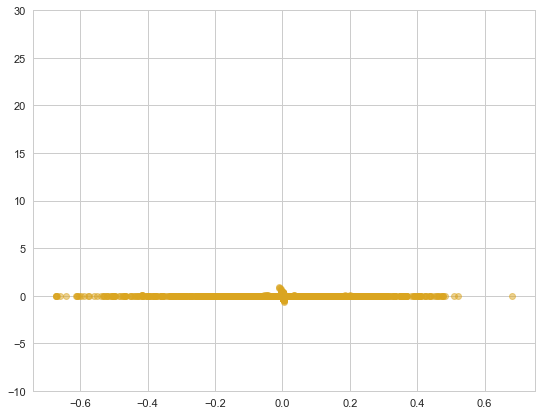

In [ ]:
plt.figure(figsize = (9,7))
plt.scatter(principalComponents[:,0],principalComponents[:,1], c='goldenrod',alpha=0.5)
plt.ylim(-10,30)
plt.show()

Podemos ver nuestros 2 componentes principales en esta gráfica. No nos da mucha luz del comportamiento de los datos pero vayamos profundizando.

In [ ]:
# Hagamos una transposición para mejor lectura

pcsSummary = pcsSummary.transpose()
pcsSummary.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Standard deviation,0.13,0.11,0.09,0.07,0.06,0.06,0.05,0.03,0.03,0.02,0.02,0.02,0.01,0.01
Proportion of variance,0.29,0.22,0.16,0.09,0.07,0.06,0.04,0.02,0.02,0.01,0.01,0.01,0.00,0.00
Cumulative proportion,0.29,0.51,0.67,0.76,0.83,0.89,0.93,0.95,0.97,0.98,0.99,0.99,1.00,1.00


Con esta tabla podemos calcular fácilmente que:

- Hasta el **componente 7** podemos acumular 82% del total de varianza

- Los componentes 0 y 1 son los que mayor valor aportan al dataset con 0.26 y 0.13 respectivamente.


Grafiquemos estos resultados para tener una mejor claridad de las cosas


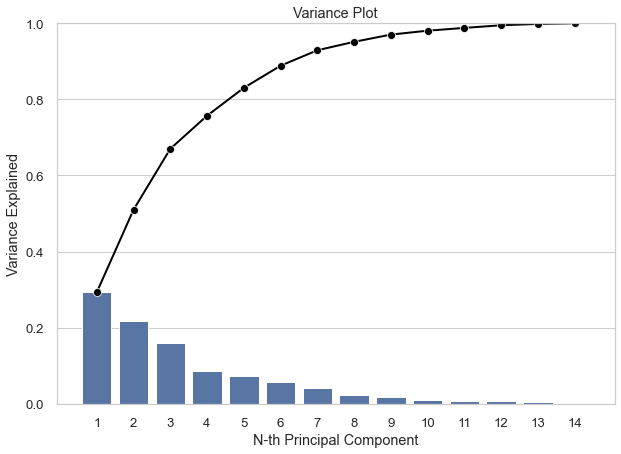

In [ ]:
# Hagamos una gráfica para representarlo y determinar el número mínimo de componentes:

import seaborn as sns

PC_components = np.arange(pcs.n_components_) + 1
#PC_components

_ = sns.set(style = 'whitegrid', 
            font_scale = 1.2
            )

fig, ax = plt.subplots(figsize=(10, 7))

_ = sns.barplot(x = PC_components, 
                y = pcs.explained_variance_ratio_, 
                color = 'b'
                )

_ = sns.lineplot(x = PC_components-1, 
                 y = np.cumsum(pcs.explained_variance_ratio_), 
                 color = 'black', 
                 linestyle = '-', 
                 linewidth = 2, 
                 marker = 'o', 
                 markersize = 8
                 )

plt.title('Variance Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()



### Insight

Da mucho valor esta gráfica, pues partimos de una matriz de `254` columnas y ahora podemos quedarnos con solo `7` de estas características.

Como habíamos mencionado, hasta el **componente 7** **tenemos alrededor del 82% de la varianza.** Consideramos suficiente esta concentración de información para nuestros análisis.

Para completar el análisis de PCA, examinemos cada una de las variables para entender cuánto aportan de información a cada componente.

In [ ]:
# Examinemos los componentes:


pcsSummary.columns = ['PC{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pcsSummary.round(4)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
Standard deviation,0.1257,0.1081,0.0929,0.0684,0.0628,0.0560,0.0468,0.0346,0.0320,0.0236,0.0199,0.0193,0.0138,0.0096
Proportion of variance,0.2931,0.2169,0.1602,0.0869,0.0732,0.0582,0.0406,0.0222,0.0190,0.0103,0.0074,0.0069,0.0035,0.0017
Cumulative proportion,0.2931,0.5100,0.6701,0.7570,0.8303,0.8884,0.9291,0.9513,0.9702,0.9805,0.9879,0.9948,0.9983,1.0000


In [ ]:
# Es necesario identificar magnitudes y direcciones de cada componente para determinar importancia de cada variable 
# en cada componente:
pd.set_option('display.max_rows', 254)

pcsComponents_dfX = pd.DataFrame(pcs.components_.transpose(), 
                                columns = pcsSummary.columns,
                                index = dfMain5.iloc[:, 0:].columns
                                )


In [ ]:
pcsComponents_dfX

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
COLI_FEC_NMP_100mL,-0.000472,0.121278,-0.006450,0.492293,-0.037798,-0.009862,-0.109083,0.530991,0.075254,0.002624,-0.000744,0.036136,0.208722,0.630063
DBO_mg/L,-0.004500,0.172322,-0.009936,0.405446,-0.023406,-0.002838,-0.017363,-0.365528,-0.066204,-0.087506,0.001683,-0.196767,0.739373,-0.271843
DQO_mg/L,-0.007339,0.216729,-0.013564,0.483014,-0.021132,0.002325,0.040877,-0.476229,-0.045817,-0.342373,0.000924,-0.137942,-0.562552,0.189101
ENTEROC_NMP_100mL,0.015616,-0.029046,0.992836,0.037168,0.108146,0.001986,0.007776,-0.006536,0.000263,-0.001894,0.001020,-0.000495,-0.000078,0.000131
E_COLI_NMP_100mL,-0.000499,0.107181,-0.005657,0.442090,-0.034049,-0.008757,-0.097859,0.461832,0.064801,0.073214,-0.001073,0.047669,-0.271103,-0.695418
OD_PORC,0.001869,-0.942014,-0.038518,0.321440,-0.015252,-0.001821,-0.002735,-0.084615,-0.013377,-0.013375,0.000376,-0.004864,-0.002758,0.002517
OD_PORC_FON,0.817113,0.001740,0.015743,-0.015392,-0.248893,-0.517152,0.005296,-0.017603,0.045674,-0.003490,0.000030,-0.002255,-0.001952,0.000527
OD_PORC_MED,0.508040,0.002284,0.002675,0.004223,-0.113570,0.850223,0.001726,0.014914,-0.075137,-0.001275,0.014688,-0.000842,0.000181,-0.000121
OD_PORC_SUP,0.271681,0.007657,-0.109608,0.054767,0.953404,-0.035305,-0.027693,0.008241,-0.002033,0.002924,0.006237,0.001097,0.001994,-0.000766
SST_mg/L,0.002332,0.017257,-0.012028,0.090974,0.020047,-0.001786,0.987497,0.113047,0.015277,0.041463,0.001842,0.004349,0.029519,-0.009679


In [ ]:

# Redondeo a 4 cifras para una mejor lectura
#pcsComponentes = pcsComponents_dfX.sort_values(by=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8",
#                                                   "PC9", "PC10", "PC11", "PC12", "PC13", "PC14","PC15",
#                                                   "PC16", "PC17"], ascending=False)



#pcsComponents_dfX = pcsComponents_dfX.T

#pComponents_dfX["Variable"] = pcsComponents_dfX.index
pcsComponents_dfX_Analisis = pcsComponents_dfX.T
#pcsComponents_dfX.reset_index(inplace=True)

#Conversión de todo el dataframe a float debido a que con la T se crea una columna en object

#pcsComponents_dfX = pcsComponents_dfX.astype(float)


#pcsComponents_dfX.reset_index(inplace=True)


#pcsComponents_dfX['Max'] = pcsComponents_dfX[pcsComponents_dfX.columns].idxmax(axis=1)
pcsComponents_dfX_Analisis= pd.concat([pcsComponents_dfX_Analisis.idxmax(axis=1), pcsComponents_dfX_Analisis.max(axis=1)], axis=1)

#Mapeo para colocar adecuadamente el nombre del nuevo dataframe de análisis

campos = {0 : "Variable", 1 :"Valor"}


pcsComponents_dfX_Analisis = pcsComponents_dfX_Analisis.rename(columns=campos)

pcsComponents_dfX_Analisis.head(17)

,Variable,Valor
PC1,OD_PORC_FON,0.817113
PC2,DQO_mg/L,0.216729
PC3,ENTEROC_NMP_100mL,0.992836
PC4,COLI_FEC_NMP_100mL,0.492293
PC5,OD_PORC_SUP,0.953404
PC6,OD_PORC_MED,0.850223
PC7,SST_mg/L,0.987497
PC8,COLI_FEC_NMP_100mL,0.530991
PC9,TOX_FIS_SUP_15_UT,0.983676
PC10,TOX_V_15_UT,0.874648


Podemos observar que el PC1 está dominado por la variable `DBO_mg/L` con **0.47**, el PC2 está dominado por la variable `TOX_D_48_SUP_UT` con **0.09** y así sucesivamente hasta los 7 componentes que utilizaremos para el k-means.

Con este análsis ya podemos reducir **50** características a solo **7**.

# 3. Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.

In [ ]:
print('Datos escalados y con OneHotEncoder antes de PCA: ', dfMain5.shape)
print('Matriz PCA: ', principalComponents.shape)
 
    
pca_df = pd.DataFrame(data=principalComponents, columns =["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9",
                                                          "PC10", "PC11", "PC12", "PC13", "PC14"])

Datos escalados y con OneHotEncoder antes de PCA:  (3493, 14)
Matriz PCA:  (3493, 14)


In [ ]:
pca_df['target'] = y
pca_df['latitud'] = lat
pca_df['longitud'] = long

pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,target,latitud,longitud
0,-0.033805,-0.005834,0.002763,-0.012444,-0.124850,0.004605,-0.005101,-0.001972,-0.001466,-0.002464,-0.001389,-0.001471,-0.003869,0.001155,Rojo,22.24730,-102.33911
1,0.253700,-0.006308,-0.010782,-0.011038,-0.036513,0.063932,-0.009045,0.004267,-0.006969,0.000557,0.002361,-0.000113,-0.000213,-0.000047,Verde,22.90473,-109.84290
2,0.253689,-0.006287,-0.011479,-0.011064,-0.036589,0.063931,-0.009050,0.004272,-0.006969,0.000559,0.002360,-0.000112,-0.000213,-0.000047,Verde,22.89880,-109.86442
3,0.117953,-0.006994,-0.009518,-0.012744,-0.032274,-0.073141,-0.008387,0.002009,0.005298,0.000873,-0.000563,0.000107,-0.000212,-0.000028,Verde,22.89609,-109.88604
4,0.279689,-0.006153,-0.011629,-0.010555,-0.028617,0.054309,-0.009323,0.004022,-0.006196,0.000511,0.002516,-0.000154,-0.000230,-0.000046,Verde,22.87694,-109.89657


### Elección solo de los componentes principales que necesitaremos.

In [ ]:
#pca_df_kmeans = pca_df
pca_df_kmeans =pca_df[pca_df.columns.difference(["target"])]

# Solo elegiremos los primeros 7 componentes principales pues demostrarmos que son los que concentran el 80% de la información

pca_df_kmeans = pca_df_kmeans[["latitud", "longitud", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"]]

#pca_df_kmeans.head()

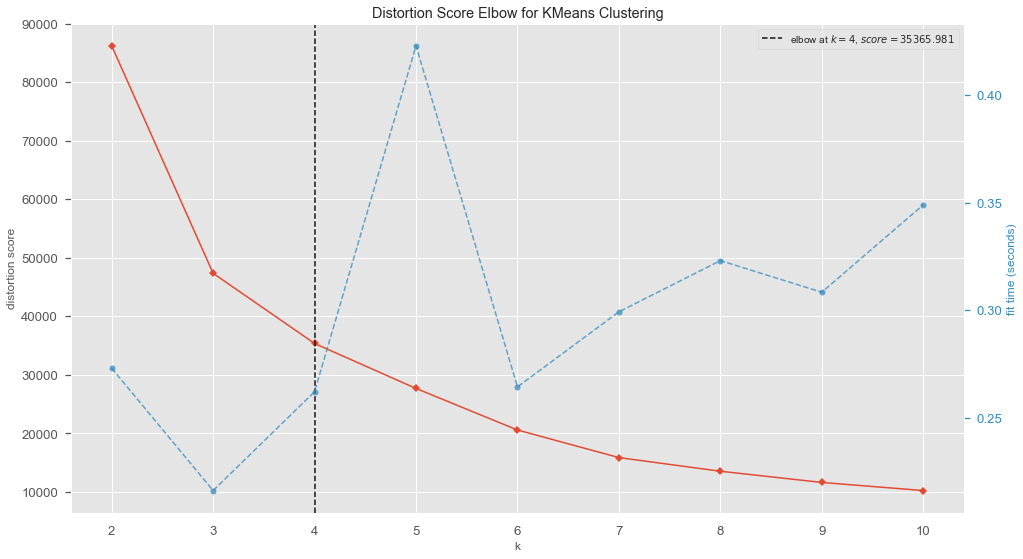

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')


#X = np.array(pca_df[["latitud", "longitud"]])
X = np.array(pca_df_kmeans)

modelo = KMeans(random_state=42)

visualizador = KElbowVisualizer(modelo, k=(2,11))
visualizador.fit(X)    
visualizador.show() 

### Insights
Con esta gráfica podemos comenzar a dilucidar que la mejor k es 4. Veamos una gráfica de silueta para entender mejor el índice de pertenencia.



Parameter: {'n_clusters': 2} Score 0.5016403932272655
Parameter: {'n_clusters': 3} Score 0.4634996675764524
Parameter: {'n_clusters': 4} Score 0.40762366116752424
Parameter: {'n_clusters': 5} Score 0.43988630167002013
Parameter: {'n_clusters': 10} Score 0.4199726387187979
Parameter: {'n_clusters': 15} Score 0.4393409748291698
Parameter: {'n_clusters': 20} Score 0.4486675507386998
Parameter: {'n_clusters': 25} Score 0.4417300210308064
Parameter: {'n_clusters': 30} Score 0.4437258393064669
Parameter: {'n_clusters': 35} Score 0.44817044016893687
Parameter: {'n_clusters': 40} Score 0.4492381115502465
Parameter: {'n_clusters': 45} Score 0.4445029185557074
Parameter: {'n_clusters': 50} Score 0.4486778323534701


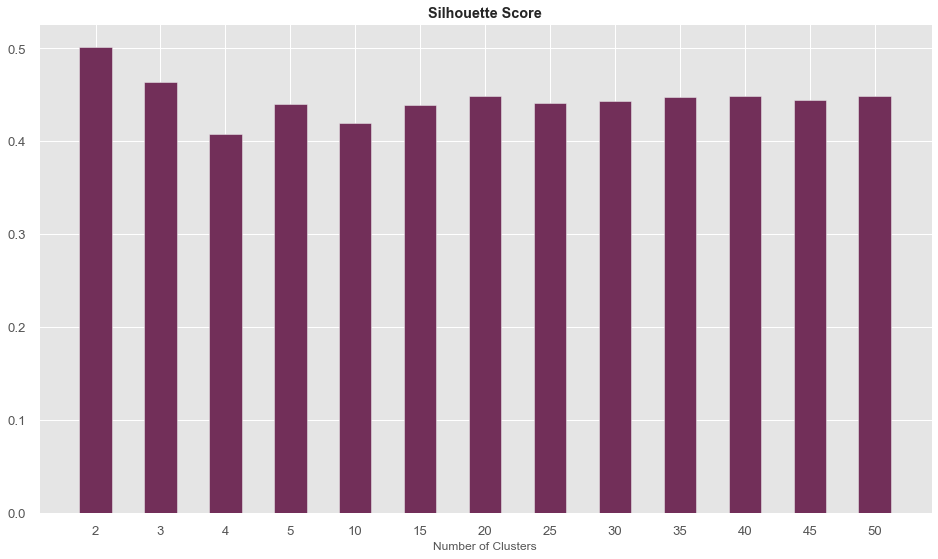

In [ ]:
# candidate values for our number of cluster
parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []


# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(pca_df_kmeans)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(pca_df_kmeans, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

### Insights
Con la gráfica de siluetas podemos ver una k = 2 pero con la gráfica de codo vemos k =5. Es parte del proceso de experimentación. Un trabajo de investigación más profundo podría confirmar o rechazar cuál es la k que se apega más a la realidad de la calidad del agua.

Para este ejercicio tomaremos la `k = 4`

In [ ]:
k = 4


clusters, centroids = KMeans_cluster(pca_df_kmeans, k)
pca_df_kmeans["cluster"] = clusters 

pca_df_kmeans["target"] = y 



In [ ]:
# Solo una breve exploración

pca_df_kmeans.head()

pca_df_kmeans["cluster"].unique()




array([1, 3, 0, 2])

In [ ]:


pca_df_kmeans["cluster"] = pca_df_kmeans["cluster"].map({0: 1,
                                                         1: 2, 
                                                         2: 3, 
                                                         3: 4})

                                                         


### Es momento de grafica los datos

# 4. Mostrar resultados de agrupamiento de latitudes y longitudes con K means en el mapa de México.

<GeoAxesSubplot:>

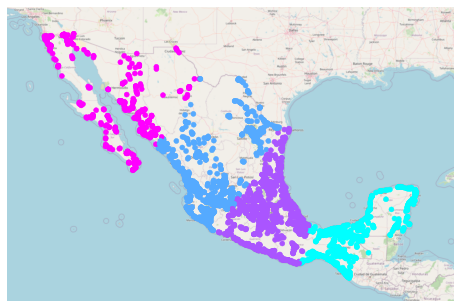

In [ ]:
pca_df_kmeans["Coordinates"] = list(zip(pca_df_kmeans.longitud, pca_df_kmeans.latitud))
pca_df_kmeans["Coordinates"] = pca_df_kmeans["Coordinates"].apply(Point)

import geoplot.crs as gcrs
import geoplot as gplt
import mapclassify as mc

polyplot_kwargs = {
     'facecolor': (0.9, 0.9, 0.9),
     'zorder': -100, 'linewidth': 0
}



gdf = gpd.GeoDataFrame(
    pca_df_kmeans, geometry=gpd.points_from_xy(pca_df_kmeans.longitud, pca_df_kmeans.latitud))

scheme = mc.Quantiles(gdf['cluster'], k=6)


ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
gplt.pointplot(gdf,  hue='cluster', ax=ax, scheme=scheme, cmap="cool")  

### Conclusiones

- Podemos observar que en efecto, existe un agrupamiento en la costa **oeste** del país, **el sur**  y llama la atención las regiones del Bajío y el noreste de México.
- Los agrupamientos se realizaron con base en los 7 componentes principales más las coordenadas de la muestra de tomas.



### Preparación final para el Reto 2

Ya tenemos identificadas los componentes principales, el target y las coordenadas. Hemos reducido de 52 dimensiones a solo 7, con esto podemos comenzar a trabajar en las labores de clasificación


In [ ]:
pca_df_kmeans.to_csv("SalidaReto2.csv", encoding="UTF-8", index=False)